# JUSTICE IAM Introduction 

##### Setting Some Dummy Policy Levers

JUSTICE model has two policy levers: Savings rate and Emissions Control Rate. To run the simulation version of the model, we need to feed the policy levers with some values. The range of both savings rate and emissions control rate are from 0 to 1.0 corresponding to 0% to 100%. 

Here we set the savings rate to the intial savings rate data of the different regions and increase it linearly to the optimal savings rate of original DICE/RICE implementation

##### Lever: Linear Emissions Control Rate

Here the emission control starts at 0, meaning no emission control and increases linearly to 100% emission control rate depending on the transistion start year and the full emission control year.

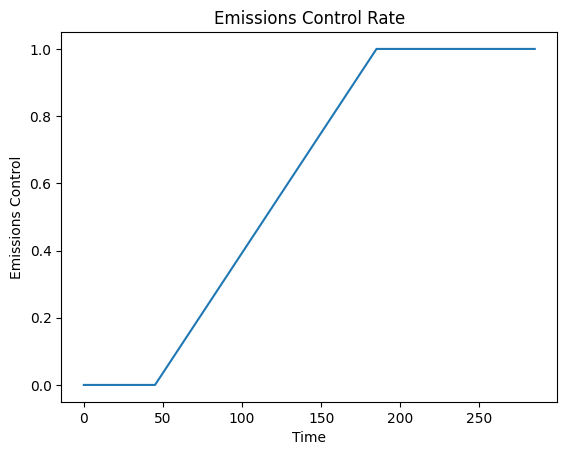

In [1]:
import numpy as np
from justice.util.data_loader import DataLoader
from justice.util.enumerations import *
from matplotlib import pyplot as plt
from justice.util.model_time import TimeHorizon

# Load the data
data_loader = DataLoader()

# Instantiate the TimeHorizon class
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)

#emissions control rate borrowed from emissions module

#Variables to be changed/deleted later
miu_initial = 0.0
min_miu = 0.0 #0.0 #1.0
min_miu_year = 2060 #9-original #8 in this model  # 2060
max_miu = 1.0
max_miu_year = 2200 #38-original #37 in this model #2205

t_min_miu = time_horizon.year_to_timestep(min_miu_year, timestep=1)
t_max_miu = time_horizon.year_to_timestep(max_miu_year, timestep=1)

#Initialize emissions control rate
emissions_control_rate = np.zeros((len(data_loader.REGION_LIST), len(time_horizon.model_time_horizon)))

for t in range(len(time_horizon.model_time_horizon)):
    
    if t < t_min_miu:       # Before time of transition
        emissions_control_rate[:,t] = min_miu
    elif t <= t_max_miu:   # Transition
        # During the transition
        emissions_control_rate[:, t] = min_miu + (max_miu - min_miu) * (t - t_min_miu)/(t_max_miu - t_min_miu)
    else:                   # After the transition
        emissions_control_rate[:, t] = max_miu


plt.plot(emissions_control_rate[0, :])
plt.title("Emissions Control Rate")
plt.xlabel("Time")
plt.ylabel("Emissions Control")
plt.show()

### JUSTICE Initialization and Run

In [2]:
from justice.model import JUSTICE
from justice.util.enumerations import *

# Instantiate the model
scenarios = 2
model = JUSTICE(
        scenario =scenarios,
        economy_type=Economy.NEOCLASSICAL,
        damage_function_type=DamageFunction.KALKUHL,
        abatement_type=Abatement.ENERDATA,
        social_welfare_function=WelfareFunction.UTILITARIAN,
        # climate_ensembles=[887, 899, 763, 4, 454, 728, 942, 543, 510, 913, 972, 384, 108, 899, 644, 607, 480, 260, 740, 177, 230, 531, 681, 468, 798, 835, 974, 401, 3, 517, 160, 151, 408, 274, 460, 541, 549, 377, 899, 278, 228, 972, 926, 116, 156, 189, 396, 414, 907, 284, 452, 510, 4, 636, 956, 859, 252, 785, 864, 299, 787, 894, 472, 254, 918, 924, 937, 95, 456, 599, 625, 485, 206, 694, 835, 376, 999, 30, 374, 729, 935, 816, 763, 136, 134, 114, 50, 533, 788, 745, 684, 510, 510, 763, 212, 364, 875, 731, 401, 476],
        stochastic_run=False, # @OPTIONAL: This is to run the FaIR model in stochastic mode. Default is True 
    )

# Run the model
model.run(emission_control_rate = emissions_control_rate, endogenous_savings_rate=True)

# Extract the data
datasets = model.evaluate() # Get the results of the simulation run


/Users/palokbiswas/Desktop/pollockdevis_git/JUSTICE/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Visualize the Output Data

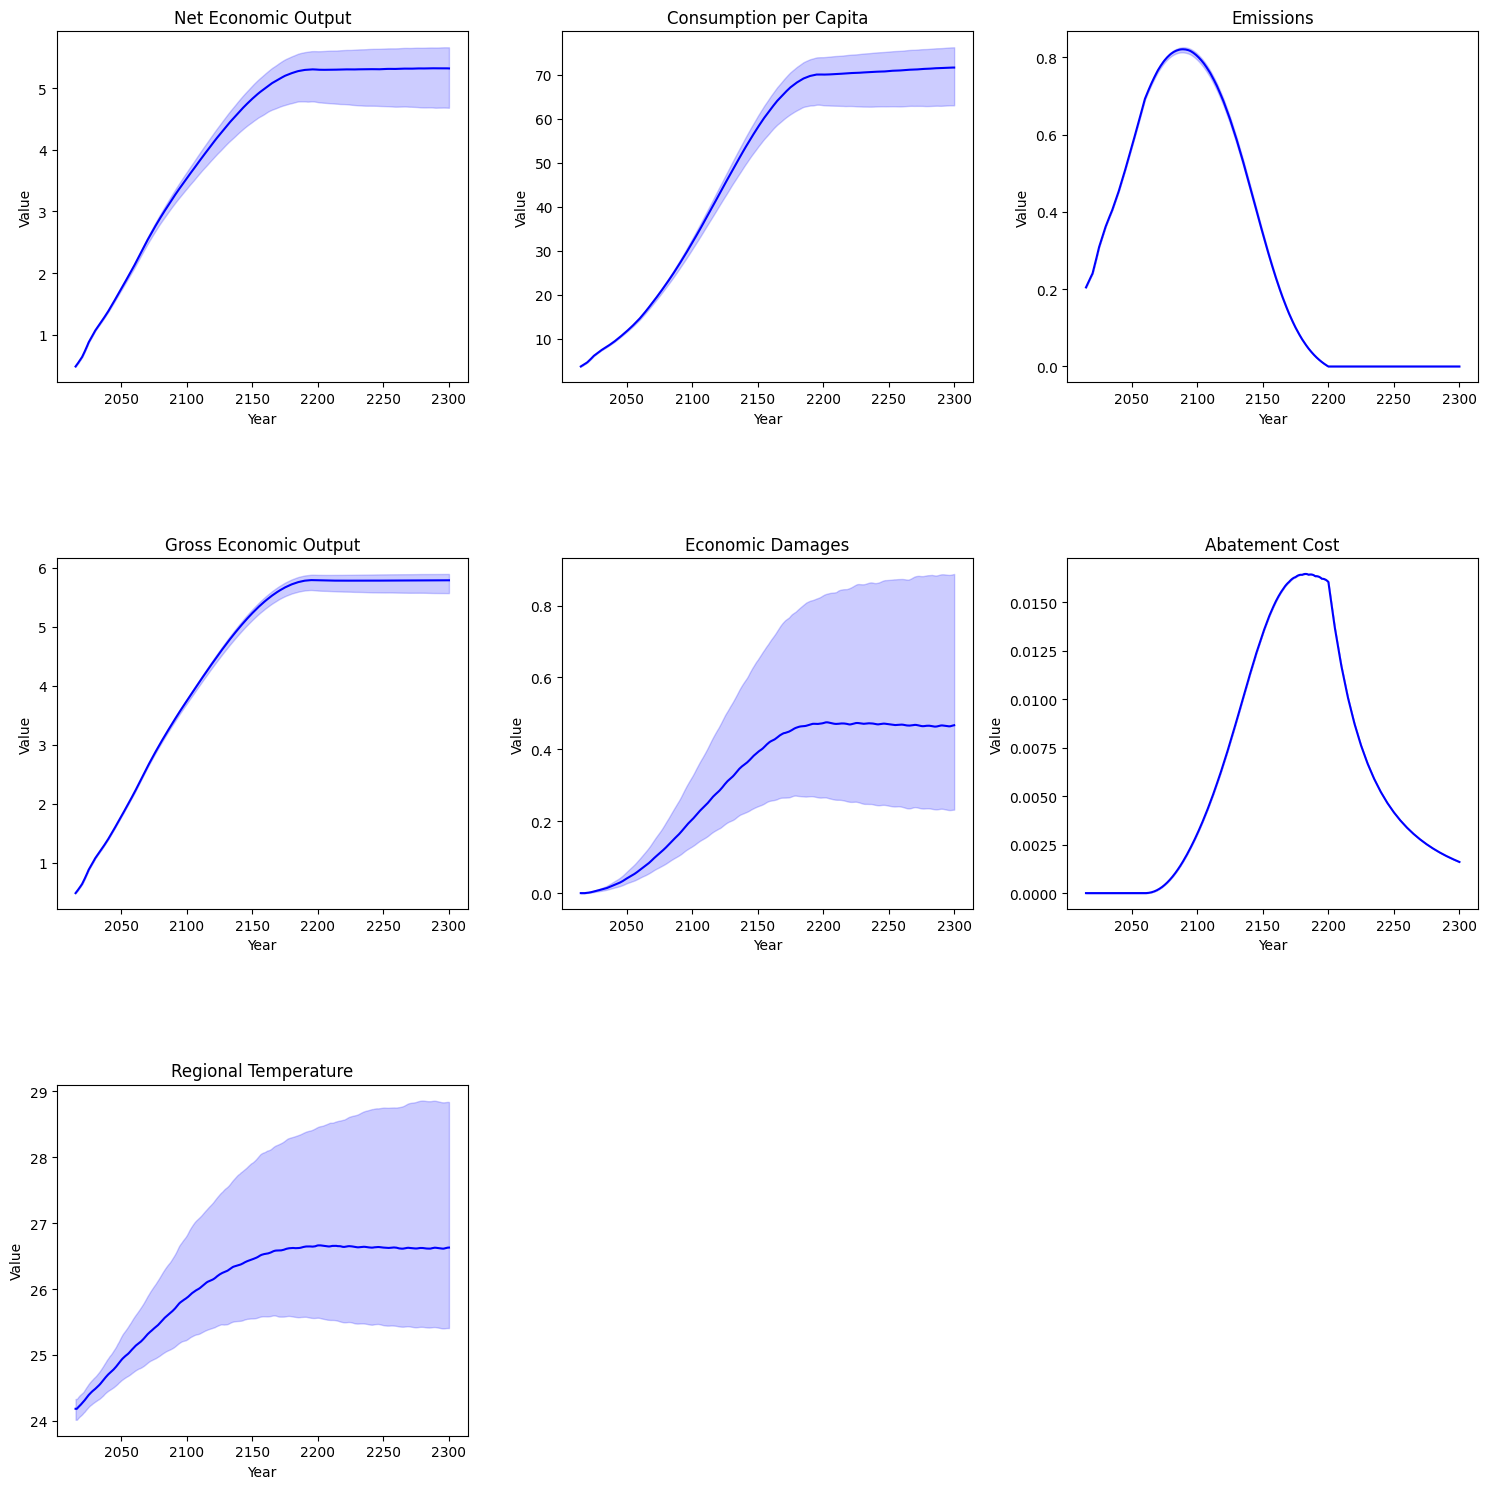

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Load the data from datasets dictionary
gross_output = datasets['gross_economic_output'] 
net_output = datasets['net_economic_output']

cpc = datasets['consumption_per_capita'] #(57, 286, 1001)
emis_control = datasets['emissions'] #(57, 286, 1001)
reg_temp = datasets['regional_temperature']
temp = datasets['global_temperature'] # (286, 1001)
damages = datasets['economic_damage'] #(57, 286, 1001)
abatecost = datasets['abatement_cost'] #(57, 286, 1001)

# Create list of all the data arrays
data_list = [net_output, cpc, emis_control, gross_output, damages, abatecost, reg_temp]
titles = ['Net Economic Output', 'Consumption per Capita', 'Emissions', 'Gross Economic Output', 'Economic Damages', 'Abatement Cost', 'Regional Temperature']

region_index = 55

# Create a figure with 3 rows and 3 columns
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the axs array to iterate over it
axs = axs.flatten()

# Iterate over the data arrays and plot them
for i, loaded_data in enumerate(data_list):
    # Select the region based on region_index
    region_data = loaded_data[region_index, :, :]

    # Calculate the 5th, 50th (median), and 95th percentiles
    p5 = np.percentile(region_data, 5, axis=1)
    p50 = np.percentile(region_data, 50, axis=1)
    p95 = np.percentile(region_data, 95, axis=1)

    # Plot the envelope
    axs[i].fill_between(time_horizon.model_time_horizon, p5, p95, color='b', alpha=0.2)

    # Plot the median line
    sns.lineplot(x=time_horizon.model_time_horizon, y=p50, ax=axs[i], color='b')

    # Set the title and axis labels
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Value')

# Remove the unused subplots
for i in range(len(data_list), len(axs)):
    fig.delaxes(axs[i])

# Adjust the layout and spacing
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()





### Plot the global temperature projections

FaIR climate model has 1001 ensemble members to represent climate uncertainty. We can select a subset of the ensemble members to speed up JUSTICE simulation. Here we select 50 ensemble members for the simulation.

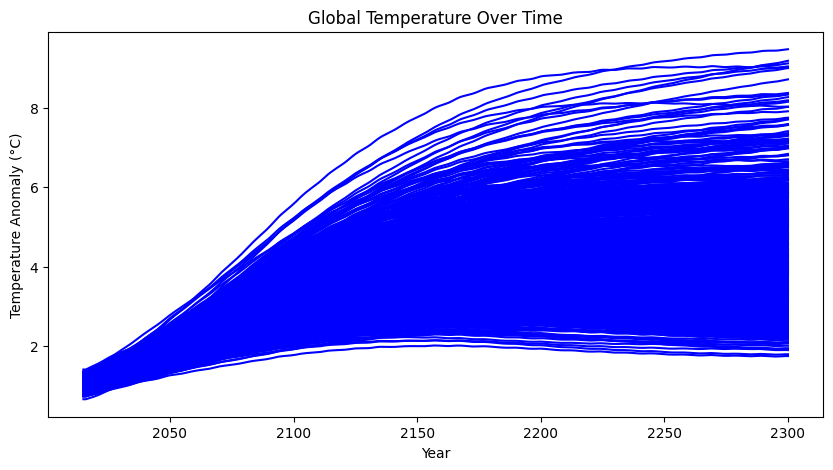

Representative indexes: [531 392 545 897 476 319 237 291 990 151 244 935 271 952 749 652 991 924
 296 396 461 892 654 757 450 120 360 518  72 160 420 275 592 777 660 464
 357 620 496 600 713 505 155 375 369  14 911 921 683 238]
Representative indexes (1-based): [532 393 546 898 477 320 238 292 991 152 245 936 272 953 750 653 992 925
 297 397 462 893 655 758 451 121 361 519  73 161 421 276 593 778 661 465
 358 621 497 601 714 506 156 376 370  15 912 922 684 239]


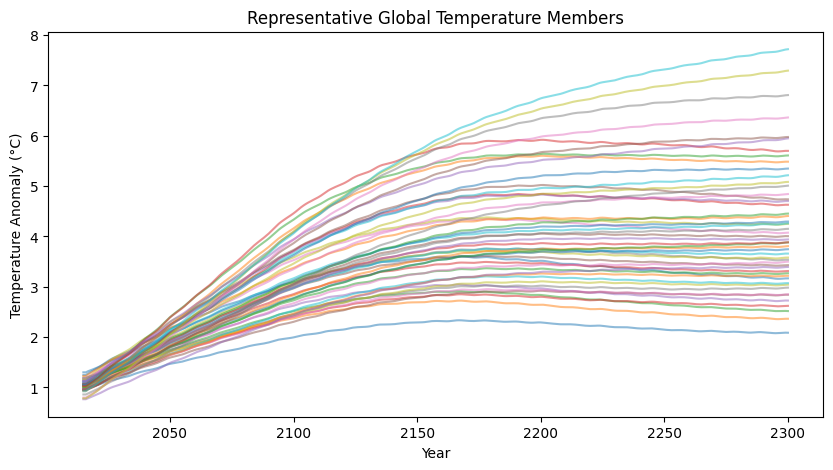

In [4]:
# Plot the temperature data
plt.figure(figsize=(10, 5))
plt.plot(time_horizon.model_time_horizon, temp, label='Global Temperature', color='blue')
plt.title('Global Temperature Over Time')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.show()

summaries = temp[-1, :]

N = 50  # number of members you want
quantile_indexes = np.argsort(summaries)
representative_indexes = []

for i in range(N):
    start = int(i * (1001 / N))
    end = int((i+1) * (1001 / N))
    idx_in_quantile = np.random.choice(quantile_indexes[start:end])
    representative_indexes.append(idx_in_quantile)

representative_indexes = np.array(representative_indexes)
print("Representative indexes:", representative_indexes)

# Print indexes but by adding 1 to each index for better readability
print("Representative indexes (1-based):", representative_indexes + 1)

# Now plot the subset of representative members
plt.figure(figsize=(10, 5))
for idx in representative_indexes:
    plt.plot(time_horizon.model_time_horizon, temp[:, idx], label=f'Member {idx}', alpha=0.5)
plt.title('Representative Global Temperature Members')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.show()


# Optimizing the Policy Levers Based on Different Principles of Distributive Justice



Checking the Distributive Justice Principles Available in the JUSTICE Model

In [5]:
from justice.util.enumerations import WelfareFunction

# Print the welfare function enums
print("Welfare Function Enums:")
for wf in WelfareFunction:
    print(f"{wf.name}: {wf.value}")

Welfare Function Enums:
UTILITARIAN: (0, 'UTILITARIAN')
PRIORITARIAN: (1, 'PRIORITARIAN')
SUFFICIENTARIAN: (2, 'SUFFICIENTARIAN')
EGALITARIAN: (3, 'EGALITARIAN')


This code generates the Pareto-optimal candidate policies based on the objectives. The output is a tar.gz containing the solutions (weights, center, radii of the RBF). This output will be used in the next step to generate the reference set from different seeds and to compute hypervolume.

In [ ]:
from analysis.analyzer import run_optimization_adaptive
import numpy as np
import random
from justice.util.enumerations import Optimizer
# Set the seed for reproducibility

seeds = [
    9845531,
    1644652,
    3569126,
    6075612,
    521475,
]
seed = seeds[4]
random.seed(seed)
np.random.seed(seed) 
config_path = 'analysis/normative_uncertainty_optimization.json' # This loads the config used in the Paper
run_optimization_adaptive(config_path = config_path,
                          swf=0, # 0 for utilitarian, 1 for prioritarian etc. See enumeration.py
                          nfe=10, # Small number for demonstration
                          seed=seed,
                          datapath = "./data",
                          optimizer=Optimizer.EpsNSGAII, 
                          )

100it [00:46,  2.16it/s]                                                       


## Analysing the Pareto-Optimal Policy Candidates per Probem Formulation

In [11]:
import plotly.graph_objects as go
import pandas as pd
from justice.util.enumerations import WelfareFunction, SSP

swf = WelfareFunction.UTILITARIAN # UTILITARIAN, PRIORITARIAN
ssp = SSP.SSP2

# Read Data
path1 = f"data/temporary/NU_DATA/combined/{str(ssp).split('.')[1]}/"
df1 = pd.read_csv(path1 + f"{swf.value[1]}_reference_set.csv")
# df1['policy_index'] = df1.index

# Only use last 2 columns
df1 = df1.iloc[:, -2:]

# Add an extra column for policy index
df1['policy_index'] = df1.index

# Create Plotly figure
fig = go.Figure()



# Set the background color to white
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(color='black'),
)

# Add the scatter plot with policy_index as hover text
fig.add_trace(
    go.Scatter(
        x=df1['fraction_above_threshold'],
        y=df1['welfare'],
        mode='markers',
        marker=dict(size=10, color='lightblue'),
        name='combined',
        text=df1['policy_index'],
        hovertemplate=
            'Temperature: %{x}<br>' +
            'Welfare: %{y}<br>' +
            'Policy Index: %{text}<extra></extra>'
    )
)

# Enable legend and axes titles
fig.update_layout(
    title='',
    xaxis_title='Temperature',
    yaxis_title='Welfare',
    legend_title='Dataset',
    width=900,
    height=600
)

# show x and y axes
fig.update_xaxes(showline=True, linewidth=2, linecolor='black' )
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')


# Add arrows to illustrate direction of preference. x axis
fig.add_annotation(
    xref='paper', yref='paper',
    x=0.5, y=-0.05,
    text='←', 
    showarrow=False,
    font=dict(size=20, color='black'),
    xanchor='left', yanchor='middle'
)

# Add arrows on y axis 
fig.add_annotation(
    xref='paper', yref='paper',
    x=-0.08, y=0.5,
    text= '↓', 
    showarrow=False,
    font=dict(size=20, color='black'),
    xanchor='center', yanchor='bottom'
)

fig.show()

## Investigate the Policy Outcomes

In [12]:
import pandas as pd
from justice.util.output_data_processor import reevaluate_optimal_policy, reevaluated_optimal_policy_variable_extractor
from justice.util.model_time import TimeHorizon
from justice.util.data_loader import DataLoader
from justice.util.enumerations import WelfareFunction, SSP

policy_index = 22 #Put the policy index here.
scenario_list = ["SSP245"] # ["SSP126","SSP245","SSP370","SSP460","SSP534"]
swf = WelfareFunction.UTILITARIAN # WelfareFunction.UTILITARIAN # WelfareFunction.PRIORITARIAN


ssp = SSP.SSP2
path = f"data/temporary/NU_DATA/combined/{str(ssp).split('.')[1]}/"
base_dir                = path
input_data_name = f"{swf.value[1]}_reference_set_idx{policy_index}.h5"
scenario = scenario_list[0] # Iterate manually through the scenarios and reset kernel every scenario

start_year = 2015
end_year = 2300
data_timestep = 5
timestep = 1

data_loader = DataLoader()
region_list = data_loader.REGION_LIST

# Set the time horizon
time_horizon = TimeHorizon(
    start_year=start_year,
    end_year=end_year,
    data_timestep=data_timestep,
    timestep=timestep,
)

list_of_years = time_horizon.model_time_horizon


print(f"Processing scenario: {scenario} with policy index: {policy_index} for {swf.value[1]}")

##############################################################################

# NOTE: The following code generates large dataframes and saved them in the data/temporary folder. Size is ~ 1.5 GB each run

reevaluate_optimal_policy(
    input_data=[
        f"{swf.value[1]}_reference_set.csv",


    ],

    path_to_rbf_weights=path,  #  reevaluation
    path_to_output=path,  #  reevaluation
    direction_of_optimization=[
        "min",
        "min",
    ],
    rbf_policy_index= policy_index, #selected_indices[0], # This chooses policy for a particular rival framing. Can also set to the index directly
    list_of_objectives=[
        "welfare",
        "fraction_above_threshold",
    ],
    scenario_list= [scenario],  
)


############################################################################################################

variable_names_and_shapes = {
    "global_temperature": 2,
    "constrained_emission_control_rate": 3,
    "emissions": 3,
}
for variable_name, data_shape in variable_names_and_shapes.items():
    reevaluated_optimal_policy_variable_extractor(
        scenario_list= [scenario],  
        region_list=region_list,
        list_of_years=list_of_years,
        path_to_data=path,  
        path_to_output=path,   
        variable_name=variable_name,
        data_shape=data_shape, # 2 for temperature, 3 for rest
        no_of_ensembles=1001,
        input_data=[
            input_data_name,
        ],
        output_file_names=[
            f"{swf.value[1]}", #_{variable_name}
        ],
    )



Processing scenario: SSP245 with policy index: 22 for UTILITARIAN
index for policy:  22
2 SSP245
Welfare:  103.52205069679432
Keys of the scenario data:  dict_keys(['SSP245'])
File saved as UTILITARIAN_reference_set_idx22 at location data/temporary/NU_DATA/combined/SSP2/
Directory:  /Users/palokbiswas/Desktop/pollockdevis_git/JUSTICE
SSP245
File saved as UTILITARIAN_idx22_SSP245_global_temperature at location data/temporary/NU_DATA/combined/SSP2
Directory:  /Users/palokbiswas/Desktop/pollockdevis_git/JUSTICE
SSP245
File saved as UTILITARIAN_idx22_SSP245_constrained_emission_control_rate at location data/temporary/NU_DATA/combined/SSP2
Directory:  /Users/palokbiswas/Desktop/pollockdevis_git/JUSTICE
SSP245
File saved as UTILITARIAN_idx22_SSP245_emissions at location data/temporary/NU_DATA/combined/SSP2


## Visualizing the Distribution of Policy Outcomes

In [6]:
import numpy as np
import plotly.express as px

import pandas as pd

from justice.util.visualizer import plot_choropleth_2D_data


fig, data = plot_choropleth_2D_data(
    path_to_data=path,
    path_to_output=path, #/rbf_dist_test
    projection= "natural earth1", 
    colourmap= px.colors.sequential.Reds,
    year_to_visualize=2050,
    input_data_path_list=[

        "PRIORITARIAN_idx1_SSP245_constrained_emission_control_rate.npy",
        # PRIORITARIAN_idx1_SSP245_constrained_emission_control_rate.npy


    ],
        
    data_label="Emission Control Rate",
    legend_label="", 
    data_normalization=True,
    saving=False,
    show_colorbar=True,
    normalized_colorbar=True,

)

fig.show()


Taking average over the last dimension.
0


In [10]:
from justice.util.visualizer import plot_emissions_comparison_with_boxplots

# Example usage
plot_emissions_comparison_with_boxplots(
    data_paths=[
        path + "PRIORITARIAN_idx1_SSP245_emissions.npy", #PRIORITARIAN_idx1_SSP245_constrained_emission_control_rate
    ],
    start_year=2015,
    end_year=2300,
    data_timestep=5,
    timestep=1,
    visualization_start_year=2024,
    visualization_end_year=2100,
    yaxis_range=[0, 70],
    opacity=0.001,
    plot_title="",
    xaxis_title="Year",
    yaxis_title="Global Emissions (GtCO2)",
    template="plotly_white",
    width=1000,
    height=700,
    baseline_path=path + "baseline_emissions_16.npy",
    output_path=path,
    saving=False,
    colors=[
        # "coral", 
        # "green",
        "rgba(252, 141, 98, 0.8)",
        # "rgba(141, 160, 203, 0.8)",#"rgba(0, 0, 255, 0.2)",
        ],
    median_colors=[
        # "red", 
        # "green",
        "rgba(252, 141, 98, 1)",
        # "rgba(141, 160, 203, 1)",
        #"rgba(0, 0, 255, 0.2)",
        ],
    baseline_color="gray",
    fontsize=16,
)

In [8]:
from justice.util.visualizer import plot_comparison_with_boxplots
from justice.util.enumerations import WelfareFunction, SSP
ssp = SSP.SSP2

path = f"data/temporary/NU_DATA/combined/{str(ssp).split('.')[1]}/"

regret_type = "Temperature_Regret" # "Welfare_Regret" or "Temperature_Regret"

plot_comparison_with_boxplots(
    data_paths=[

        # Prioritarian Welfare Regret
        # path + "PRIORITARIAN_emissions_idx6_SSP126_emissions.npy",
        # path + "PRIORITARIAN_emissions_idx6_SSP245_emissions.npy",
        # path + "PRIORITARIAN_emissions_idx6_SSP370_emissions.npy",
        # path + "PRIORITARIAN_emissions_idx6_SSP460_emissions.npy",
        # path + "PRIORITARIAN_emissions_idx6_SSP534_emissions.npy",

        # Prioritarian Temperature Regret
        path + "PRIORITARIAN_idx1_SSP245_emissions.npy",
        # path + "PRIORITARIAN_emissions_idx8_SSP245_emissions.npy",
        # path + "PRIORITARIAN_emissions_idx8_SSP370_emissions.npy",
        # path + "PRIORITARIAN_emissions_idx8_SSP460_emissions.npy",
        # path + "PRIORITARIAN_emissions_idx8_SSP534_emissions.npy",

        # Utilitarian Welfare Regret
        # path + "UTILITARIAN_emissions_idx29_SSP126_emissions.npy",
        # path + "UTILITARIAN_emissions_idx29_SSP245_emissions.npy",
        # path + "UTILITARIAN_emissions_idx29_SSP370_emissions.npy",
        # path + "UTILITARIAN_emissions_idx29_SSP460_emissions.npy",
        # path + "UTILITARIAN_emissions_idx29_SSP534_emissions.npy",

        # Utilitarian Temperature Regret
        # path + "UTILITARIAN_emissions_idx4_SSP126_emissions.npy",
        # path + "UTILITARIAN_emissions_idx4_SSP245_emissions.npy",
        # path + "UTILITARIAN_emissions_idx4_SSP370_emissions.npy",
        # path + "UTILITARIAN_emissions_idx4_SSP460_emissions.npy",
        # path + "UTILITARIAN_emissions_idx4_SSP534_emissions.npy",
    
    ],
    labels=[
        
        # 'SSP1',
        'SSP2',
        # 'SSP3',
        # 'SSP4',
        # 'SSP5',
        ], 
    start_year=2015,
    end_year=2300,
    data_timestep=5,
    timestep=1,
    visualization_start_year=2015,
    visualization_end_year=2100,
    yaxis_range=[0, 80],
    plot_title=' ',
    xaxis_title='Year',
    yaxis_title='Global Emissions (GtCO2)',
    template='plotly_white',
    width=1000,
    height=700,
    output_path=path +"/"+ "plots",
    saving=True,
    show_red_dashed_line=False,
    show_interquartile_range=True,
    linecolors=[
 

        "rgba(141,211,199, 1)",
        "rgba(254,217,166, 1)", 
        # "rgba(190,186,218, 1)", 
        # "rgba(128,177,211, 1)", 
        # "rgba(251,128,114, 1)", 
        ],
    colors = [ 

        "rgba(141,211,199, 0.4)", 
        "rgba(254,217,166, 0.4)",
        # "rgba(190,186,218, 0.4)", 
        # "rgba(128,177,211, 0.4)", 
        # "rgba(251,128,114, 0.4)", 

        ],
    first_plot_proportion=[0, 0.75],
    second_plot_proportion=[0.85, 1],
    transpose_data=True,
    show_min_max = False,
    dtick=10,
    output_name_suffix=regret_type,
)

Data is 3D
Shape of data:  (57, 286, 1001)
Shape of data after summing:  (286, 1001)


/Users/palokbiswas/Desktop/pollockdevis_git/JUSTICE/justice/util/visualizer.py:2645: FutureWarning:



The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.



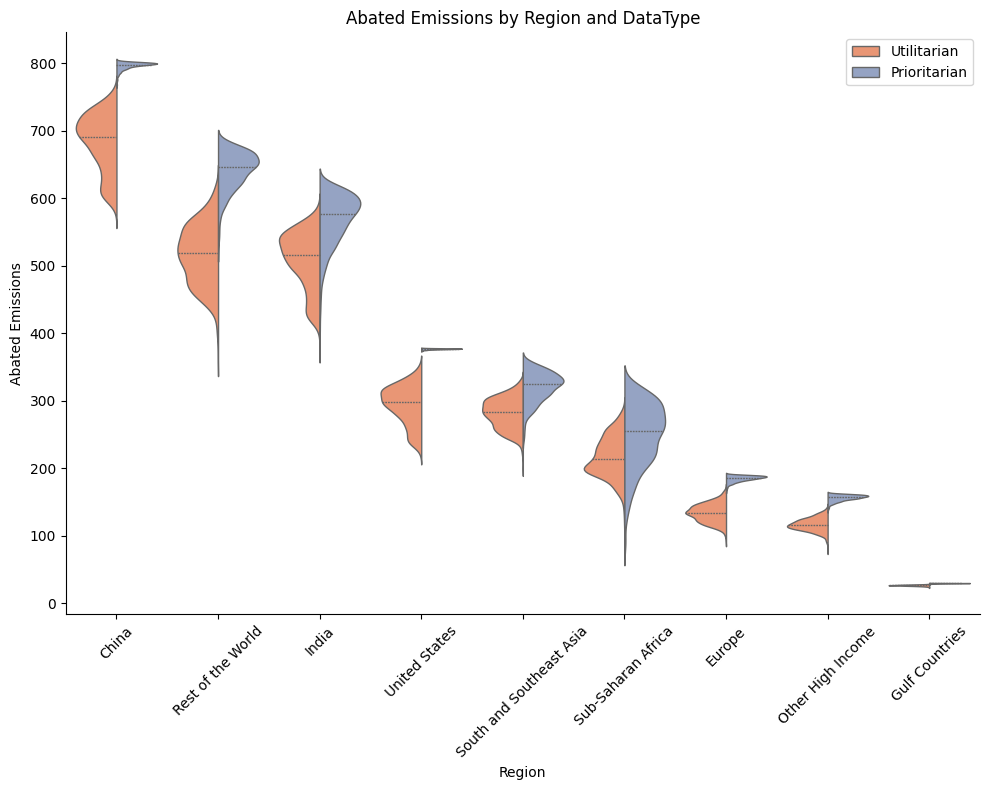

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from justice.util.model_time import TimeHorizon
from justice.util.data_loader import DataLoader
import json

from justice.util.visualizer import plot_violin_comparison_sorted
from justice.util.enumerations import WelfareFunction, SSP
ssp = SSP.SSP2

path = f"data/temporary/NU_DATA/combined/{str(ssp).split('.')[1]}/"

# Usage Example:
plt, economic_dataframes = plot_violin_comparison_sorted(
    baseline_path=path + "baseline_emissions_16.npy",
    utilitarian_path= path + "UTILITARIAN_idx22_SSP245_emissions.npy", 
    prioritarian_path= path + "PRIORITARIAN_idx1_SSP245_emissions.npy",
    region_mapping_path="data/input/9_regions.json",
    rice_region_dict_path="data/input/rice50_regions_dict.json",
    start_year=2015,
    end_year=2300,
    splice_start_year=2025,
    splice_end_year=2100,
    color_palette=['#fc8d62', '#8da0cb'],
    datanames=['Utilitarian', 'Prioritarian'],
    plot_title='Abated Emissions by Region and DataType',
    x_axis_title='Region',
    y_axis_title='Abated Emissions',
    path_to_output="data/plots/only_welfare_temp",
    output_file_name="abated_emissions_utilitarian_vs_prioritarian_violin_v3",
    saving=False,
)

plt.show()